<a href="https://colab.research.google.com/github/SJSY126/gasyori100/blob/master/01_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q  --user numpy matplotlib opencv-python sklearn scikit-image --upgrade

     |████████████████████████████████| 14.6MB 297kB/s 
     |████████████████████████████████| 12.4MB 49.6MB/s 
     |████████████████████████████████| 28.2MB 137kB/s 
     |████████████████████████████████| 12.4MB 46.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


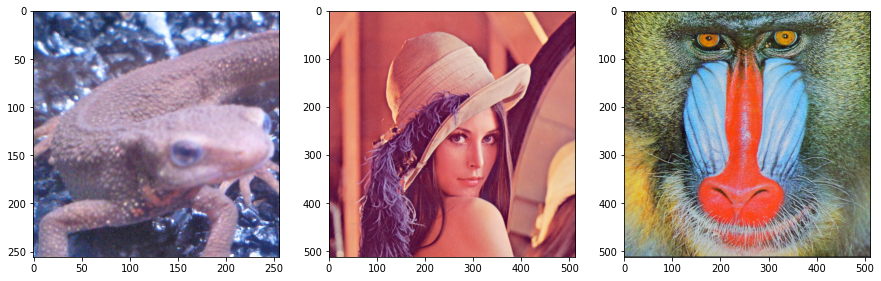

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256.png')
img_lena = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp')
img_mandrill = io.imread('http://www.mis.med.akita-u.ac.jp/~kata/image/originalsource/mandrill.jpg')


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.imshow(img_lena)
plt.subplot(1,3,3)
plt.imshow(img_mandrill)
plt.show()

In [0]:
# func_list

def rgb2gray(img):
    _img = img.copy().astype(np.float32)
    img_gray = 0.2126*_img[...,0] + 0.7153*_img[...,1] + 0.0722*_img[...,2]
    img_gray = np.clip(img_gray,0,255)
    return img_gray.astype(np.uint8)

def binary(img_gray,th):
    _img = img_gray.copy().astype(np.float32)
    img_binary = np.minimum(_img//th, 1)
    img_binary = np.clip(img_binary,0,255)
    return img_binary.astype(np.uint8)

def rgb2binary(img,th):
    _img = img.copy().astype(np.float32)
    img_gray = rgb2gray(_img)
    img_binary = binary(img_gray,th)
    return img_binary

def otsu_thresh(img):
    _img = img.copy().astype(np.float32)

    max_vari = -1
    max_th = -1

    for th in range(1,254):
        m0 = _img[_img <= th].mean()
        m1 = _img[_img >  th].mean()
        w0 = _img[_img <= th].size
        w1 = _img[_img > th].size
        vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) 
        if vari > max_vari:
            max_vari = vari
            max_th = th

    return rgb2binary(_img, max_th), max_th

def rgb2hsv(img_rgb):
    #rgb -> hsv
    _img = img_rgb.copy().astype(np.float32)

    v_max = _img.max(axis=2)
    v_min = _img.min(axis=2)
    v_argmin = _img.argmin(axis=2)

    img_hsv = np.zeros_like(_img, dtype=np.float32)

    r, g, b = np.split(_img, 3, axis=2)
    r, g, b = r[..., 0], g[..., 0], b[..., 0]

    diff = np.maximum(v_max - v_min, 1e-10)

    #Hue
    ind = v_argmin == 2
    img_hsv[..., 0][ind] = 60 * (g - r)[ind] / diff[ind] + 60
    ind = v_argmin == 0
    img_hsv[..., 0][ind] = 60 * (b - g)[ind] / diff[ind] + 180
    ind = v_argmin == 1
    img_hsv[..., 0][ind] = 60 * (r - b)[ind] / diff[ind] + 300
    ind = v_max == v_min
    img_hsv[..., 0][ind] = 0
    # Saturation
    img_hsv[..., 1] = v_max - v_min
    # Value
    img_hsv[..., 2] = v_max

    return img_hsv

def hsv2rgb(img_hsv):
    #hsv -> rgb
    _img_hsv = img_hsv.copy().astype(np.float32)

    h, s, v = np.split(_img_hsv, 3, axis=2)
    h, s, v = h[..., 0], s[..., 0], v[..., 0]
    _h = h / 60
    x = s * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(x)
    vals = np.array([[s, x, z], [x, s, z], [z, s, x], [z, x, s], [x, z, s], [s, z, x]])
    
    img_rgb = np.zeros_like(_img_hsv)
    
    for i in range(6):
        ind = _h.astype(int) == i
        for j in range(3):
            img_rgb[..., j][ind] = (v - s)[ind] + vals[i, j][ind]
            
    return np.clip(img_rgb, 0, 255).astype(np.uint8)


def color_subtraction(img,div):
    _img = img.copy().astype(np.float32)

    th = 256 // div
    return np.clip(_img // th * th + th // 2, 0 ,255).astype(np.uint8)

def ave_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].mean()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def max_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].max()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def gaussian_filter(img, ksize, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    temp = np.zeros_like(_img)

    new_h, new_w = temp.shape[:2]
    c = 1 if len(temp.shape)==2 else temp.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              temp[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = temp[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def median_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.median(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

#01 チャネル入れ替え

In [4]:
img_orig.shape

(256, 256, 3)

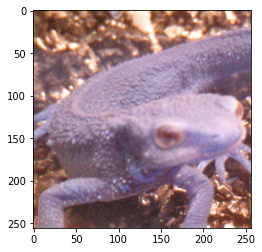

In [5]:
ans = img_orig[...,::-1]
plt.imshow(ans)
plt.show()

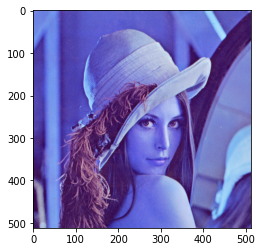

In [6]:
ans = img_lena[...,::-1]
plt.imshow(ans)
plt.show()

#02 グレースケール

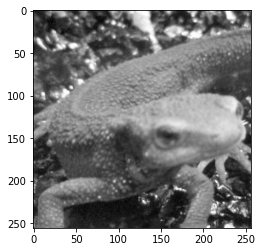

In [7]:
_img = img_orig.copy().astype(np.float32)
ans=0.2126*_img[...,0]+0.7153*_img[...,1]+0.0722*_img[...,2]
ans = np.clip(ans,0,255).astype(np.uint8)
plt.imshow(ans, cmap="gray")
plt.show()

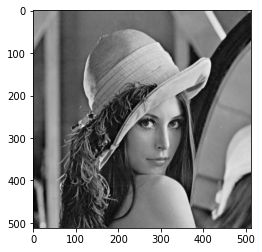

In [8]:
gray = rgb2gray(img_lena)
plt.imshow(gray, cmap="gray")
plt.show()

#03 二値化

255


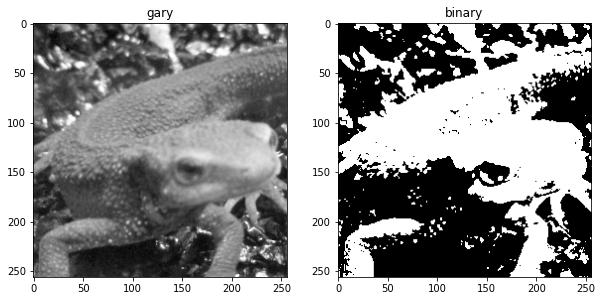

In [9]:
_img = img_orig.copy().astype(np.float32)
gray = rgb2gray(_img)
ans = np.minimum(gray//128, 1)*255
print(ans[100,100])
ans = ans.astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("gary")
plt.imshow(gray, cmap='gray')
plt.subplot(1,2,2)
plt.title("binary")
plt.imshow(ans, cmap="gray")
plt.show()

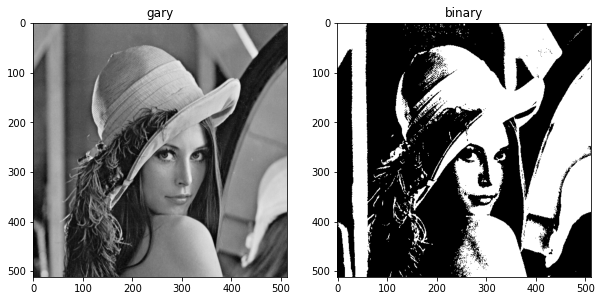

In [10]:
ans = rgb2binary(img_lena,128)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("gary")
plt.imshow(rgb2gray(img_lena), cmap='gray')
plt.subplot(1,2,2)
plt.title("binary")
plt.imshow(ans, cmap="gray")
plt.show()

#04 大津の二値化

http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html



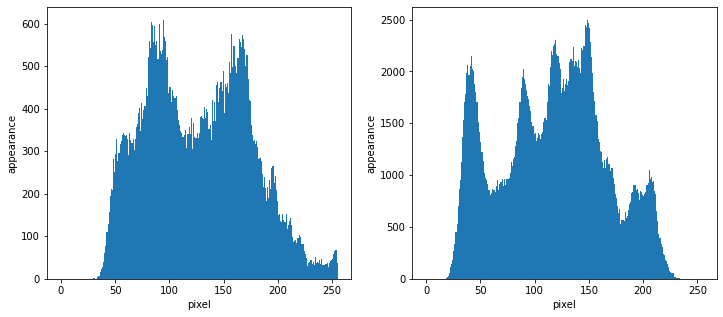

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(rgb2gray(img_orig).ravel(), bins=255, range=(0, 255))
plt.xlabel('pixel')
plt.ylabel('appearance')

plt.subplot(1,2,2)
plt.hist(rgb2gray(img_lena).ravel(), bins=255, range=(0, 255))
plt.xlabel('pixel')
plt.ylabel('appearance')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


thresh: 135


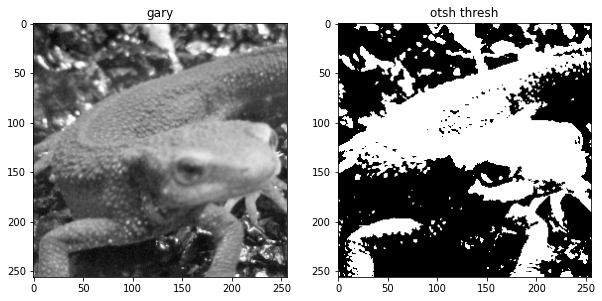

In [12]:
_img = img_orig.copy().astype(np.float32)

max_vari = -1
max_th = -1

for th in range(1,254):
    m0 = _img[_img <= th].mean()
    m1 = _img[_img >  th].mean()
    w0 = _img[_img <= th].size
    w1 = _img[_img > th].size
    vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) 
    if vari > max_vari:
        max_vari = vari
        max_th = th

img_otsu_th = rgb2binary(_img,max_th) 
print("thresh:", max_th)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("gary")
plt.imshow(gray, cmap='gray')
plt.subplot(1,2,2)
plt.title("otsh thresh")
plt.imshow(img_otsu_th, cmap="gray")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


thresh: 141


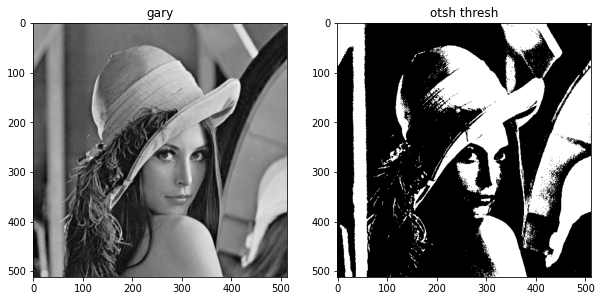

In [13]:
img_otsu_th, th = otsu_thresh(img_lena) 
print("thresh:", th)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("gary")
plt.imshow(rgb2gray(img_lena), cmap='gray')
plt.subplot(1,2,2)
plt.title("otsh thresh")
plt.imshow(img_otsu_th, cmap="gray")
plt.show()

#05 HSV変換

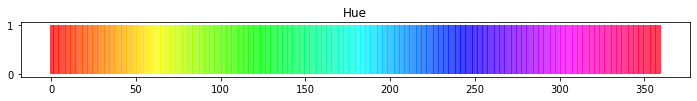

In [14]:
from matplotlib import cm
plt.figure(figsize=(12, 1))
plt.title('Hue')
for i in range(360):
    plt.vlines(i, 0, 1, color=cm.hsv(i / 360))
plt.show()

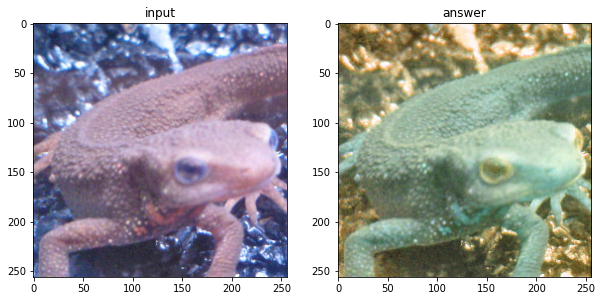

In [15]:
img_hsv = rgb2hsv(img_orig) 
img_hsv[..., 0] = (img_hsv[..., 0] + 180) % 360 
ans = hsv2rgb(img_hsv) 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(ans)
plt.show()

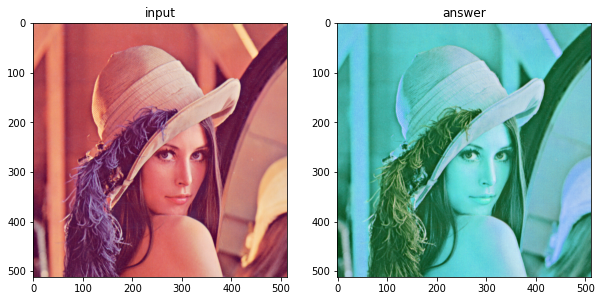

In [16]:
img_hsv = rgb2hsv(img_lena) 
img_hsv[..., 0] = (img_hsv[..., 0] + 180) % 360 
ans = hsv2rgb(img_hsv) 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_lena)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(ans)
plt.show()

# H, S, Vの値を見る

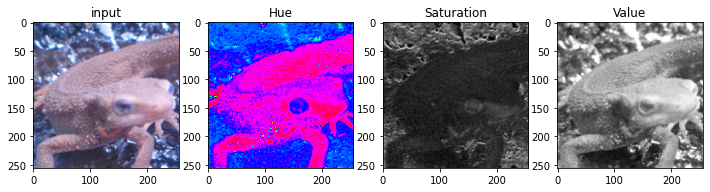

In [17]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(img_orig)

hsv  = rgb2hsv(img_orig) 

plt.subplot(1, 4, 2)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(1, 4, 3)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

plt.show()

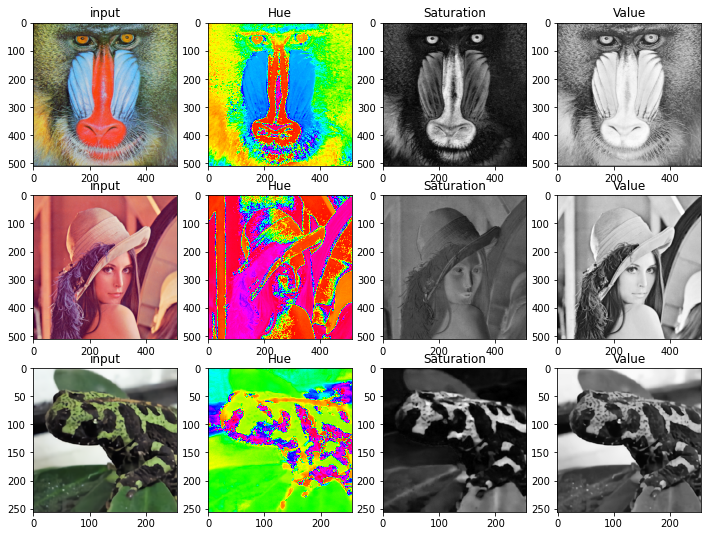

In [18]:
plt.figure(figsize=(12, 9))
plt.subplot(3, 4, 1)
plt.title('input')
plt.imshow(img_mandrill)

hsv  = rgb2hsv(img_mandrill) 

plt.subplot(3, 4, 2)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(3, 4, 3)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(3, 4, 4)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

plt.subplot(3, 4, 5)
plt.title('input')
plt.imshow(img_lena)

hsv  = rgb2hsv(img_lena) 

plt.subplot(3, 4, 6)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(3, 4, 7)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(3, 4, 8)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

img_madara_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/madara_256x256.png')

plt.subplot(3, 4, 9)
plt.title('input')
plt.imshow(img_madara_orig)

hsv  = rgb2hsv(img_madara_orig) 

plt.subplot(3, 4, 10)
plt.title('Hue')
plt.imshow(hsv[..., 0] / 360, cmap='hsv')

plt.subplot(3, 4, 11)
plt.title('Saturation')
plt.imshow(hsv[..., 1], cmap='gray')

plt.subplot(3, 4, 12)
plt.title('Value')
plt.imshow(hsv[..., 2], cmap='gray')

plt.show()

#06 減色


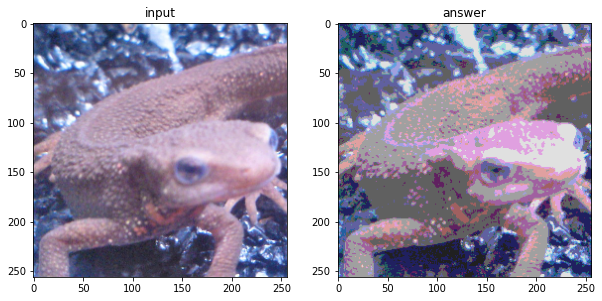

In [38]:
_img = img_orig.copy().astype(np.float32)

th = 256 // 4
ans = np.clip(_img // th * th + th // 2, 0 ,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(ans)
plt.show()

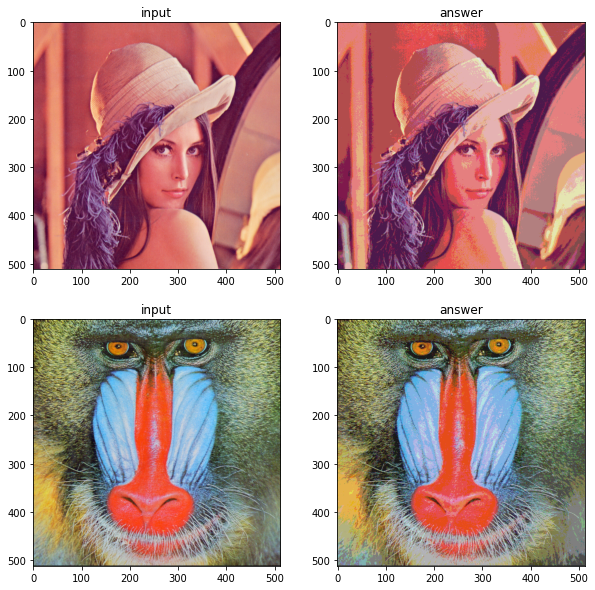

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('input')
plt.imshow(img_lena)
plt.subplot(2, 2, 2)
plt.title('answer')
plt.imshow(color_subtraction(img_lena, 5))
plt.subplot(2, 2, 3)
plt.title('input')
plt.imshow(img_mandrill)
plt.subplot(2, 2, 4)
plt.title('answer')
plt.imshow(color_subtraction(img_mandrill, 5))
plt.show()

#07 平均プーリング

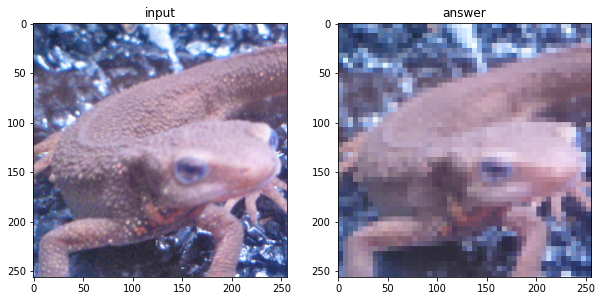

In [22]:
_img = img_orig.copy().astype(np.float32)

ksize = 5

h, w = _img.shape[:2]
outer_h = h % ksize
pad_top = outer_h // 2
pad_bottom = outer_h - pad_top
outer_w = w % ksize
pad_left = outer_w // 2
pad_right = outer_w - pad_left

_img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape) == 2 else out.shape[2]

for iy in range(0, new_h, ksize):
    for ix in range(0, new_w, ksize):
      for ic in range(c):
        out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].mean()

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

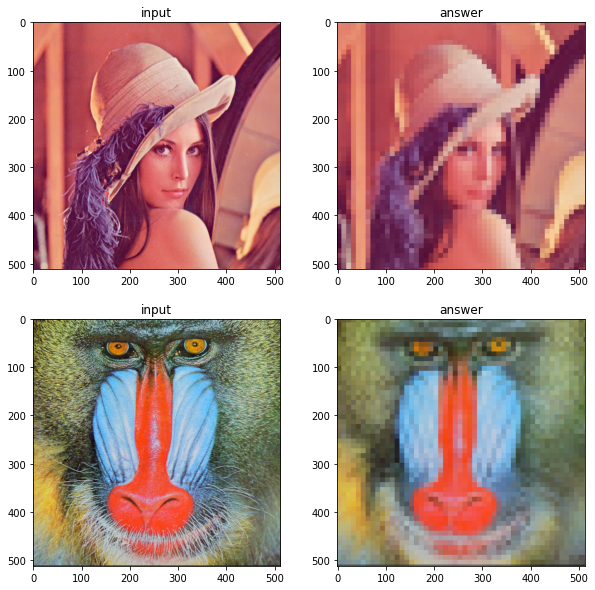

In [25]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('input')
plt.imshow(img_lena)
plt.subplot(2, 2, 2)
plt.title('answer')
plt.imshow(ave_pooling(img_lena, 10))
plt.subplot(2, 2, 3)
plt.title('input')
plt.imshow(img_mandrill)
plt.subplot(2, 2, 4)
plt.title('answer')
plt.imshow(ave_pooling(img_mandrill, 10))
plt.show()

#08 最大プーリング

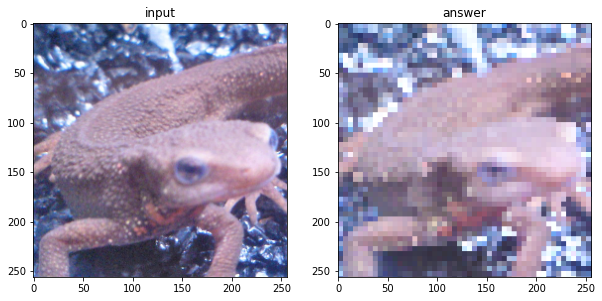

In [27]:
_img = img_orig.copy().astype(np.float32)

ksize = 5

h, w = _img.shape[:2]
outer_h = h % ksize
pad_top = outer_h // 2
pad_bottom = outer_h - pad_top
outer_w = w % ksize
pad_left = outer_w // 2
pad_right = outer_w - pad_left

_img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape) == 2 else out.shape[2]

for iy in range(0, new_h, ksize):
    for ix in range(0, new_w, ksize):
      for ic in range(c):
        out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].max()

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

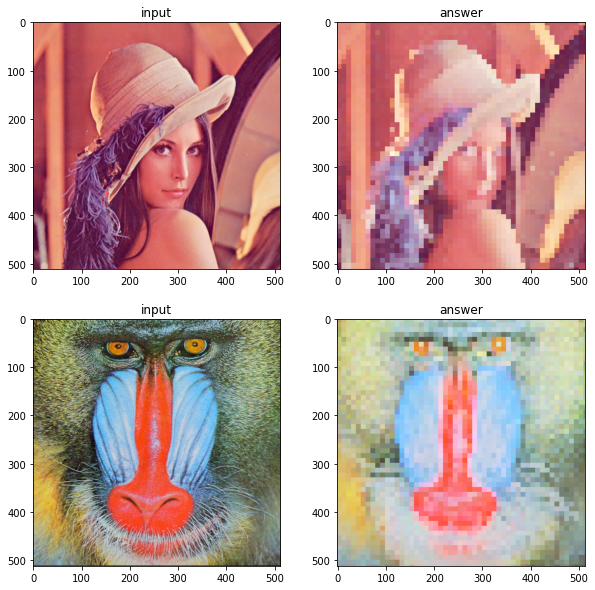

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('input')
plt.imshow(img_lena)
plt.subplot(2, 2, 2)
plt.title('answer')
plt.imshow(max_pooling(img_lena, 10))
plt.subplot(2, 2, 3)
plt.title('input')
plt.imshow(img_mandrill)
plt.subplot(2, 2, 4)
plt.title('answer')
plt.imshow(max_pooling(img_mandrill, 10))
plt.show()

#09 ガウシアンフィルタ

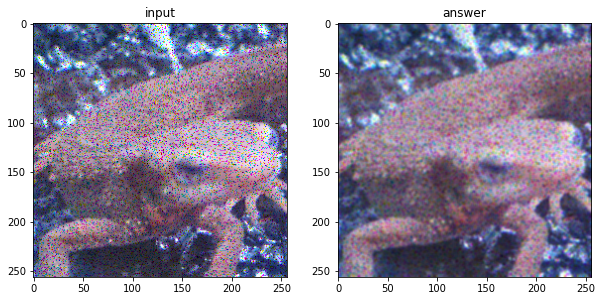

In [15]:
img_noise_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')

_img = img_noise_orig.copy().astype(np.float32)
ksize = 3
sigma = 1.3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.zeros([ksize, ksize])
for iy in range(ksize):
    for ix in range(ksize):
        k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

k = k/k.sum()

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

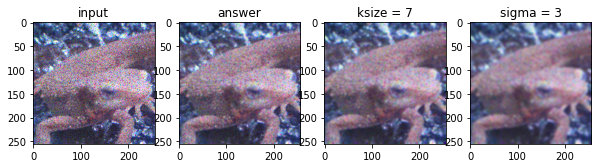

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(img_noise_orig)

plt.subplot(1, 4, 2)
plt.title('answer')
img_gau = gaussian_filter(img_noise_orig, 3, 1.3)
plt.imshow(img_gau)

plt.subplot(1, 4, 3)
plt.title('ksize = 7')
img_gau = gaussian_filter(img_noise_orig, 7, 1.3)
plt.imshow(img_gau)

plt.subplot(1, 4, 4)
plt.title('sigma = 3')
img_gau = gaussian_filter(img_noise_orig, 7, 3)
plt.imshow(img_gau)
plt.show()

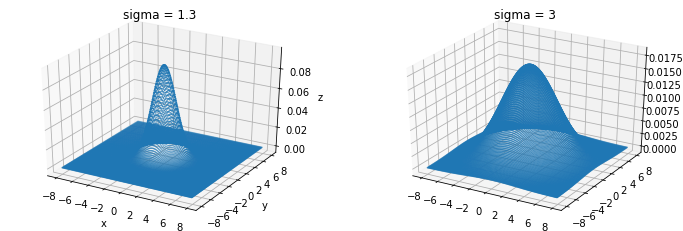

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def gaussian(sigma):
    x = np.arange(-8, 8, 0.1) 
    y = np.arange(-8, 8, 0.1)
    x, y = np.meshgrid(x, y)
    z = 1 / (2 * np.pi * (sigma ** 2)) * np.exp(- (x ** 2 + y ** 2) / (2 * sigma ** 2))
    return x, y, z

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x, y, z = gaussian(1.3)
ax.scatter3D(x, y, z, s=1, marker='.')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('sigma = 1.3')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
x, y, z = gaussian(3)
ax2.scatter3D(x, y, z, s=1, marker='.')
ax2.set_title('sigma = 3')

plt.show()

#10 メディアンフィルタ

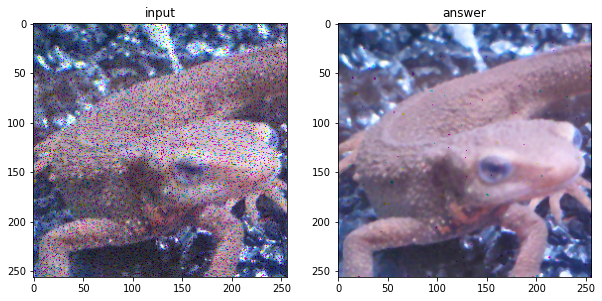

In [23]:
img_noise_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')

_img = img_noise_orig.copy().astype(np.float32)
ksize = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
            out[iy,ix,ic] = np.median(_img[iy:iy+ksize, ix:ix+ksize, ic])

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

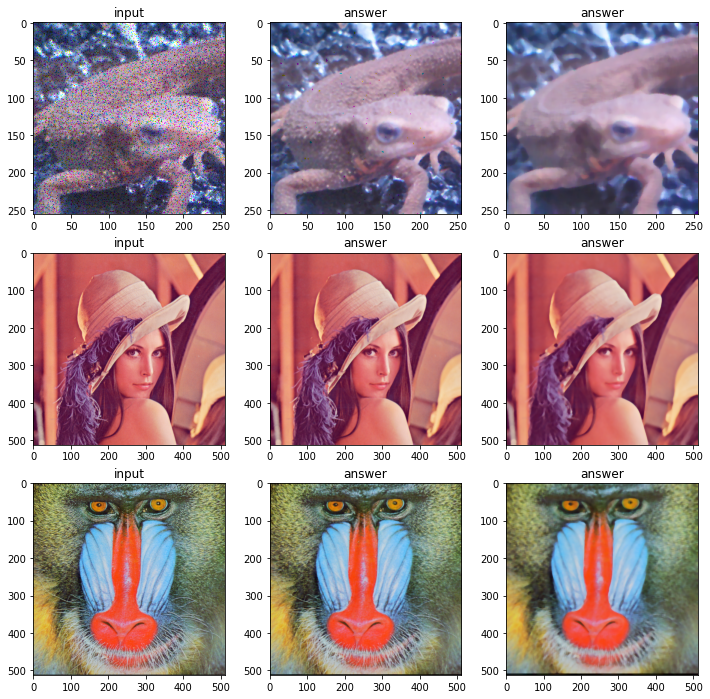

In [29]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_noise_orig)

plt.subplot(3, 3, 2)
plt.title('answer')
img_med = median_filter(img_noise_orig, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 3)
plt.title('answer')
img_med = median_filter(img_noise_orig, 7)
plt.imshow(img_med)

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena)

plt.subplot(3, 3, 5)
plt.title('answer')
img_med = median_filter(img_lena, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 6)
plt.title('answer')
img_med = median_filter(img_lena, 7)
plt.imshow(img_med)

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill)

plt.subplot(3, 3, 8)
plt.title('answer')
img_med = median_filter(img_mandrill, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 9)
plt.title('answer')
img_med = median_filter(img_mandrill, 7)
plt.imshow(img_med)

plt.show()